# Dataset Activation Spectrum for InceptionV1 Mixed4a

This notebook finds diverse ImageNet samples showing the **full activation spectrum** of neurons in InceptionV1's `mixed4a` layer, inspired by [Distill.pub Feature Visualization](https://distill.pub/2017/feature-visualization/).

For each neuron, we track 5 categories:

| Category | Description |
|----------|-------------|
| **Minimum** | Images that most suppress the neuron (most negative activation) |
| **Slightly Negative** | Images just below the activation threshold |
| **Slightly Positive** | Images that barely activate the neuron |
| **Maximum** | Images that most strongly activate the neuron |
| **Optimized** | Synthetic gradient-ascent visualization (torch-lucent) |

This reveals what each neuron has learned to detect vs. avoid.

## 1. Setup & Configuration

In [1]:
import os
import sys
from pathlib import Path

# Add src to path for local imports
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Load environment variables
from dotenv import load_dotenv
load_dotenv(project_root / ".env")

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2070


In [2]:
# Configuration
CONFIG = {
    "num_neurons": 10,           # First 10 neurons of mixed4a (512 total)
    "samples_per_category": 9,    # 9 samples per category (min, slight-, slight+, max)
    "max_samples": 10000,         # Process 10k samples from ImageNet
    "batch_size": 128,             # Batch size for streaming
    "layer_name": "mixed4a",      # Target layer in InceptionV1
    "wandb_project": "vision-interpretability",
    "wandb_run_name": "mixed4a-activation-spectrum",
    "generate_optimized": True,   # Generate gradient-ascent visualizations
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  num_neurons: 10
  samples_per_category: 9
  max_samples: 10000
  batch_size: 128
  layer_name: mixed4a
  wandb_project: vision-interpretability
  wandb_run_name: mixed4a-activation-spectrum
  generate_optimized: True


## 2. WANDB Initialization

In [3]:
import wandb

# Initialize WANDB run
run = wandb.init(
    project=CONFIG["wandb_project"],
    name=CONFIG["wandb_run_name"],
    config=CONFIG,
)

print(f"WANDB Run: {run.url}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


WANDB Run: https://wandb.ai/cataluna84/vision-interpretability/runs/1olpoehn


## 3. Load InceptionV1 Model

In [4]:
from lucent.modelzoo import inceptionv1

# Load pretrained InceptionV1
model = inceptionv1(pretrained=True)
model.to(device).eval()

print("InceptionV1 loaded successfully!")
print(f"\nModel layers containing 'mixed4a':")
for name, module in model.named_modules():
    if "mixed4a" in name:
        print(f"  {name}: {type(module).__name__}")

InceptionV1 loaded successfully!

Model layers containing 'mixed4a':
  mixed4a_1x1_pre_relu_conv: Conv2d
  mixed4a_3x3_bottleneck_pre_relu_conv: Conv2d
  mixed4a_5x5_bottleneck_pre_relu_conv: Conv2d
  mixed4a_pool_reduce_pre_relu_conv: Conv2d
  mixed4a_3x3_pre_relu_conv: Conv2d
  mixed4a_5x5_pre_relu_conv: Conv2d
  mixed4a_pool: MaxPool2dLayer
  mixed4a_1x1: RedirectedReluLayer
  mixed4a_3x3_bottleneck: RedirectedReluLayer
  mixed4a_5x5_bottleneck: RedirectedReluLayer
  mixed4a_pool_reduce: RedirectedReluLayer
  mixed4a_3x3: RedirectedReluLayer
  mixed4a_5x5: RedirectedReluLayer
  mixed4a: CatLayer


In [5]:
from segment_3_dataset_images.activation_pipeline import (
    ActivationExtractor,
    ActivationSpectrumTrackerV2,
    SampleRecord,
)

# Register forward hook on mixed4a
extractor = ActivationExtractor(model, CONFIG["layer_name"])

# Initialize spectrum tracker
tracker = ActivationSpectrumTrackerV2(
    num_neurons=CONFIG["num_neurons"],
    samples_per_category=CONFIG["samples_per_category"],
)

print(f"Tracking {CONFIG['num_neurons']} neurons with {CONFIG['samples_per_category']} samples per category")

Tracking 10 neurons with 9 samples per category


## 4. Configure ImageNet Streaming

In [6]:
from segment_3_dataset_images.activation_pipeline import ImageNetStreamer

# Setup streaming from HuggingFace
streamer = ImageNetStreamer(
    batch_size=CONFIG["batch_size"],
    max_samples=CONFIG["max_samples"],
)

print(f"Streaming up to {CONFIG['max_samples']:,} samples from ImageNet-1k")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Estimated batches: {CONFIG['max_samples'] // CONFIG['batch_size']}")

Streaming up to 10,000 samples from ImageNet-1k
Batch size: 128
Estimated batches: 78


## 5. Batch Processing & Activation Extraction

In [7]:
# Process batches and track activation spectrum
total_processed = 0
batch_count = 0

print("Processing batches...")

for tensors, images, labels, ids in tqdm(streamer, desc="Batches"):
    # Move to device
    tensors = tensors.to(device)
    
    # Forward pass (hooks capture activations)
    with torch.no_grad():
        _ = model(tensors)
    
    # Get max activations per channel
    activations = extractor.get_max_activations_per_channel()
    
    # Update tracker with first num_neurons channels
    tracker.update(
        activations[:, :CONFIG["num_neurons"]],
        images,
        ids,
        labels,
    )
    
    total_processed += len(tensors)
    batch_count += 1
    
    # Log progress to WANDB every 10 batches
    if batch_count % 10 == 0:
        wandb.log({
            "batch": batch_count,
            "samples_processed": total_processed,
        })

print(f"\nProcessed {total_processed:,} samples in {batch_count} batches")

Processing batches...


Batches: 0it [00:00, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/294 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/ILSVRC/imagenet-1k/resolve/49e2ee26f3810fb5a7536bbf732a7b07389a47b5/data/train-00000-of-00294.parquet
Retrying in 1s [Retry 1/5].



Processed 10,000 samples in 79 batches


## 6. Generate Optimized Examples (Gradient Ascent)

In [8]:
from lucent.optvis import render

optimized_images = {}

if CONFIG["generate_optimized"]:
    print(f"Generating optimized examples for {CONFIG['num_neurons']} neurons...")
    
    for n in tqdm(range(CONFIG["num_neurons"]), desc="Optimizing"):
        try:
            objective = f"{CONFIG['layer_name']}:{n}"
            result = render.render_vis(
                model,
                objective,
                show_image=False,
                show_inline=False,
                thresholds=(512,),
            )
            
            if result and len(result) > 0:
                img_array = result[0][0]
                img_array = (img_array * 255).astype(np.uint8)
                optimized_images[n] = Image.fromarray(img_array)
            else:
                optimized_images[n] = None
                
        except Exception as e:
            print(f"  Failed neuron {n}: {e}")
            optimized_images[n] = None
    
    print(f"Generated {sum(1 for v in optimized_images.values() if v is not None)} optimized images")
else:
    print("Skipping optimized example generation")

Generating optimized examples for 10 neurons...


Optimizing:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:29<00:00, 17.23it/s]

Generated 10 optimized images


## 7. Visualize Activation Spectrum

In [9]:
def plot_neuron_spectrum(neuron_idx, spectrum, optimized_img=None, figsize=(16, 4)):
    """
    Plot the activation spectrum for a single neuron.
    
    Shows: Minimum | Slightly- | Slightly+ | Maximum | Optimized
    """
    categories = ["minimum", "slight_negative", "slight_positive", "maximum"]
    titles = ["Minimum\n(most suppressing)", "Slightly Negative\n(near threshold)", 
              "Slightly Positive\n(barely activating)", "Maximum\n(most activating)"]
    
    # Determine grid size
    k = CONFIG["samples_per_category"]
    ncols = 5  # 4 categories + optimized
    nrows = k
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(f"Neuron {neuron_idx} ({CONFIG['layer_name']})", fontsize=14, fontweight="bold")
    
    # Plot each category
    for col, (cat, title) in enumerate(zip(categories, titles)):
        samples = spectrum.get(cat, [])
        
        # Set column title on first row
        if nrows > 1:
            axes[0, col].set_title(title, fontsize=10)
        else:
            axes[col].set_title(title, fontsize=10)
        
        for row in range(k):
            ax = axes[row, col] if nrows > 1 else axes[col]
            ax.axis("off")
            
            if row < len(samples):
                sample = samples[row]
                if isinstance(sample.image, Image.Image):
                    ax.imshow(sample.image)
                    ax.set_xlabel(f"act={sample.activation:.2f}", fontsize=8)
    
    # Plot optimized in last column
    col = 4
    if nrows > 1:
        axes[0, col].set_title("Optimized\n(gradient ascent)", fontsize=10)
        # Merge all rows for optimized image
        for row in range(nrows):
            axes[row, col].axis("off")
        if optimized_img is not None:
            # Show in middle row
            mid = nrows // 2
            axes[mid, col].imshow(optimized_img)
    else:
        axes[col].set_title("Optimized\n(gradient ascent)", fontsize=10)
        axes[col].axis("off")
        if optimized_img is not None:
            axes[col].imshow(optimized_img)
    
    plt.tight_layout()
    return fig

Visualizing activation spectrum for 10 neurons...



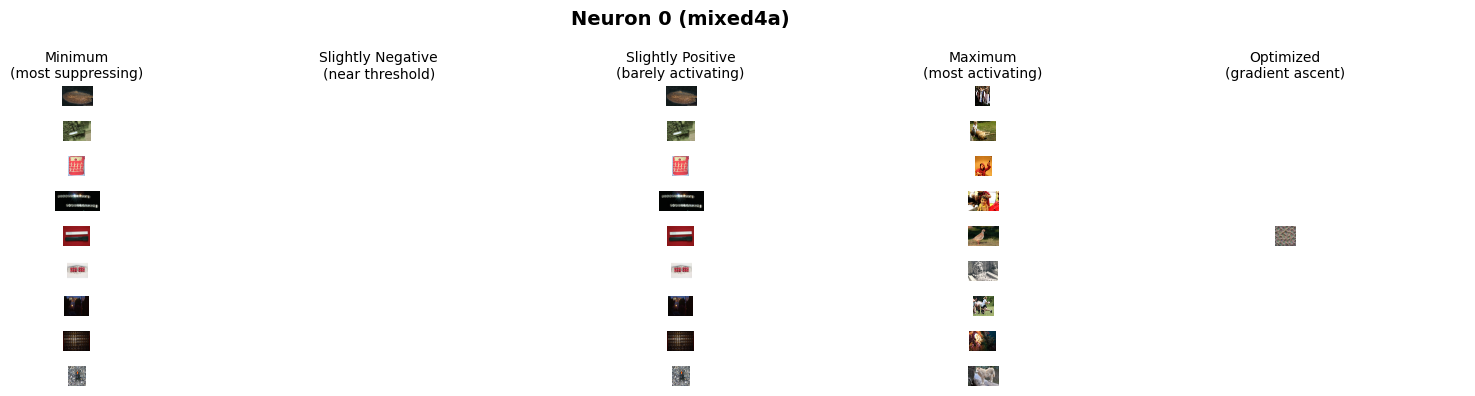

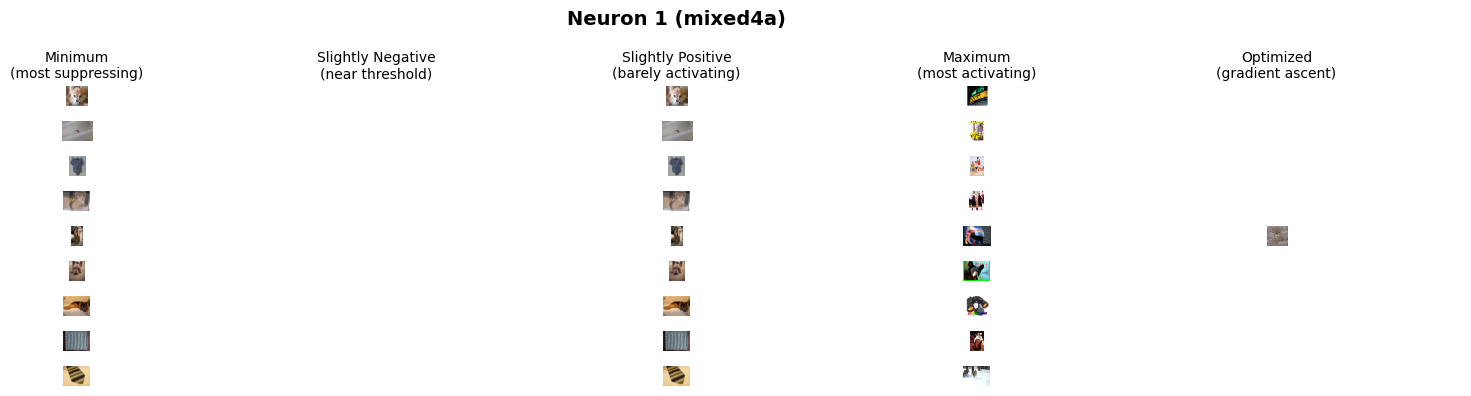

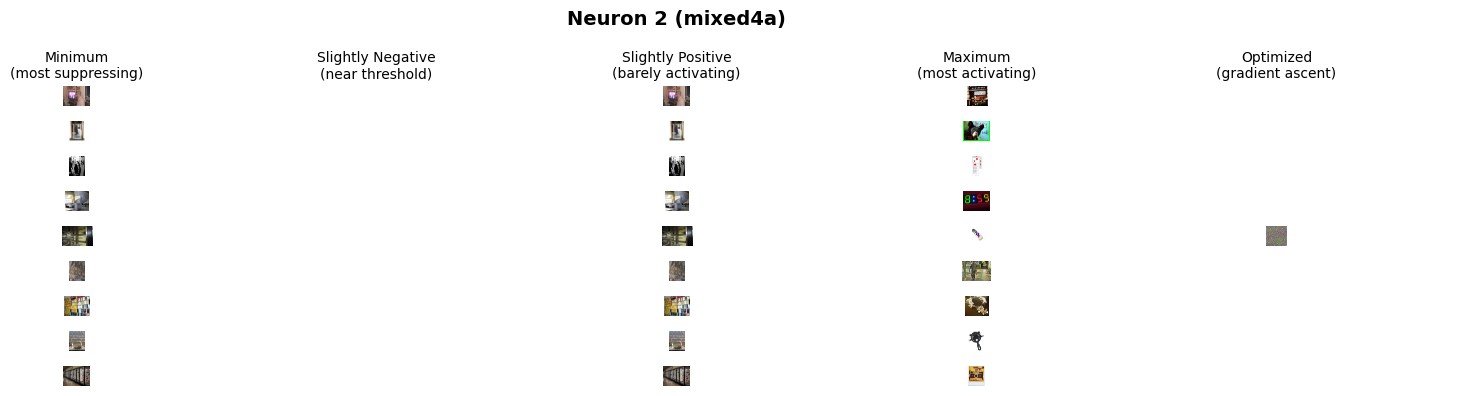

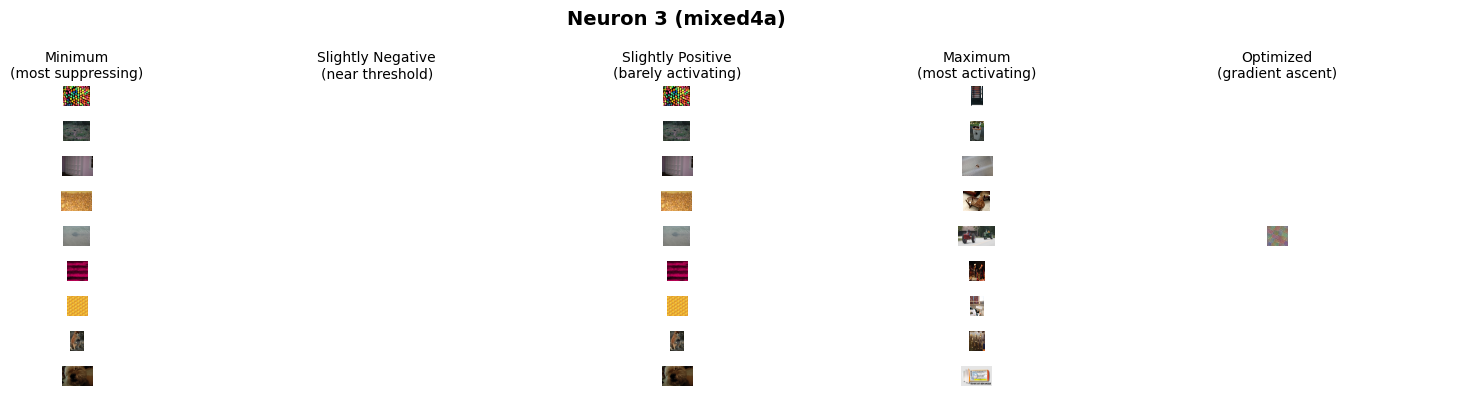

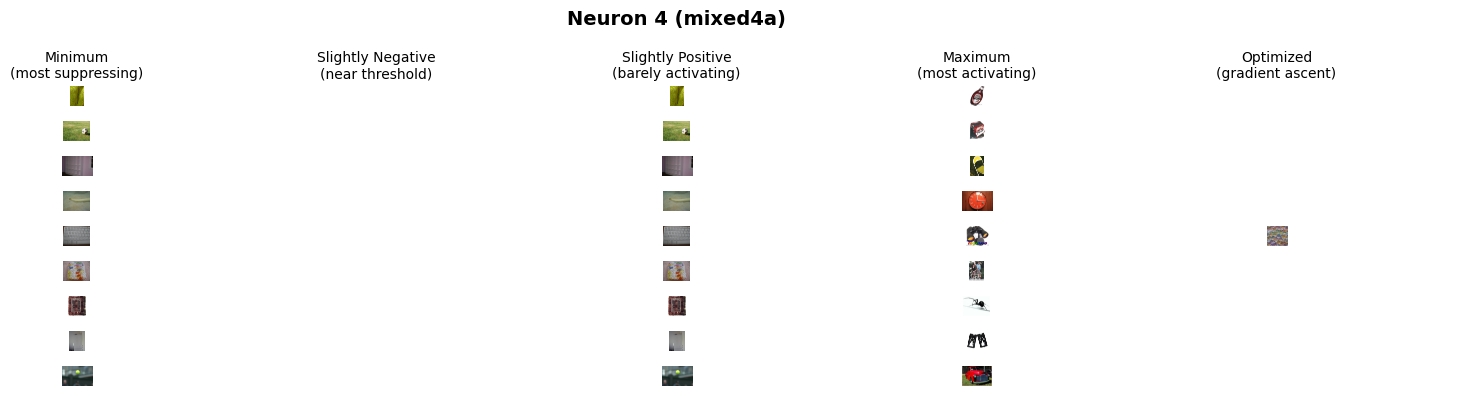

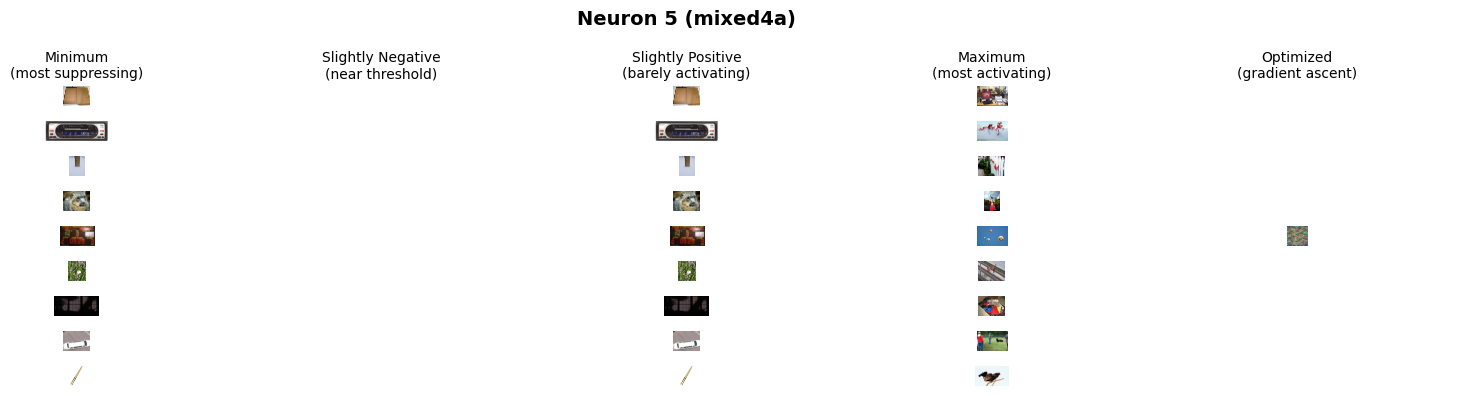

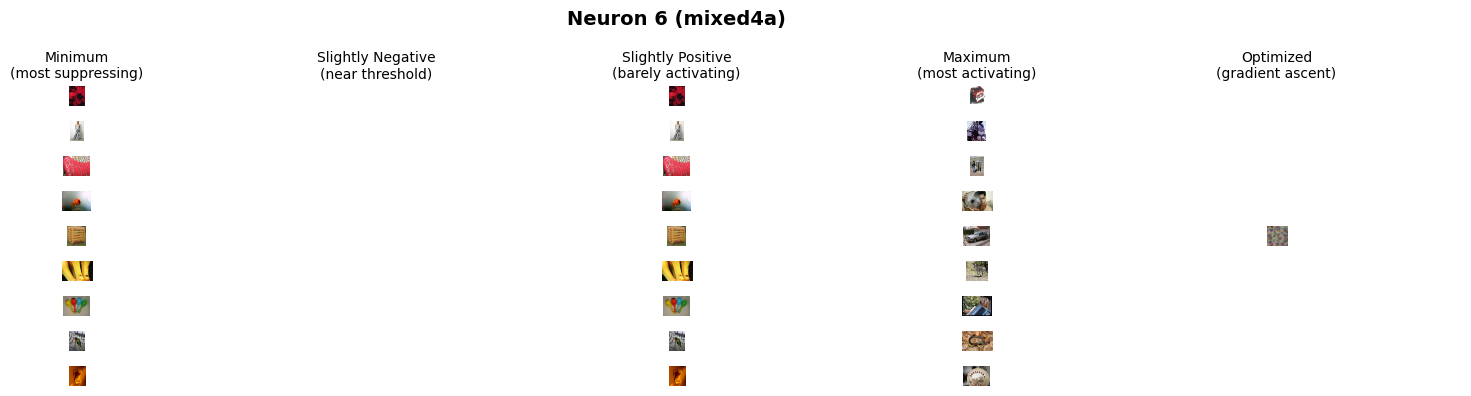

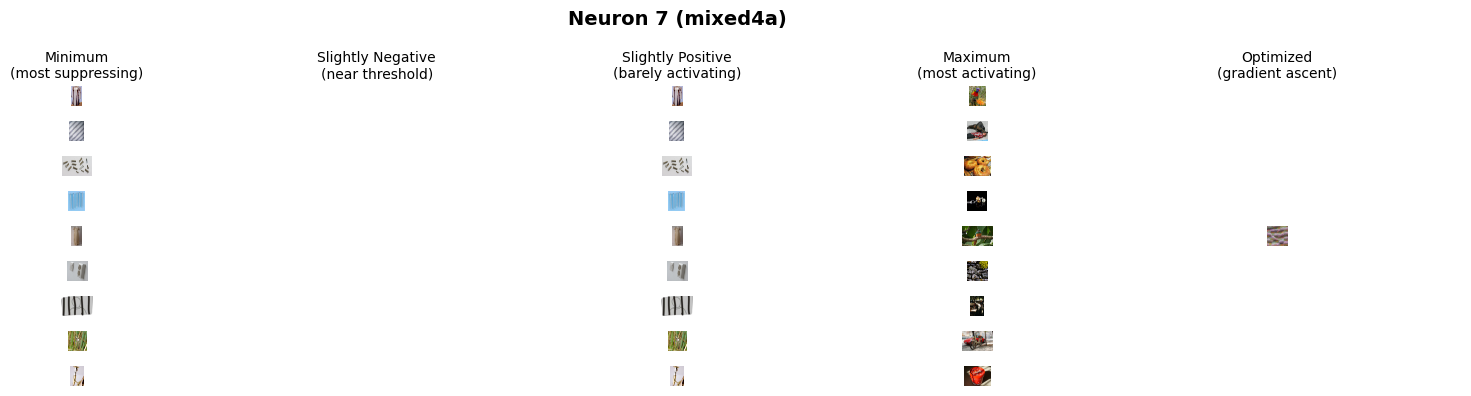

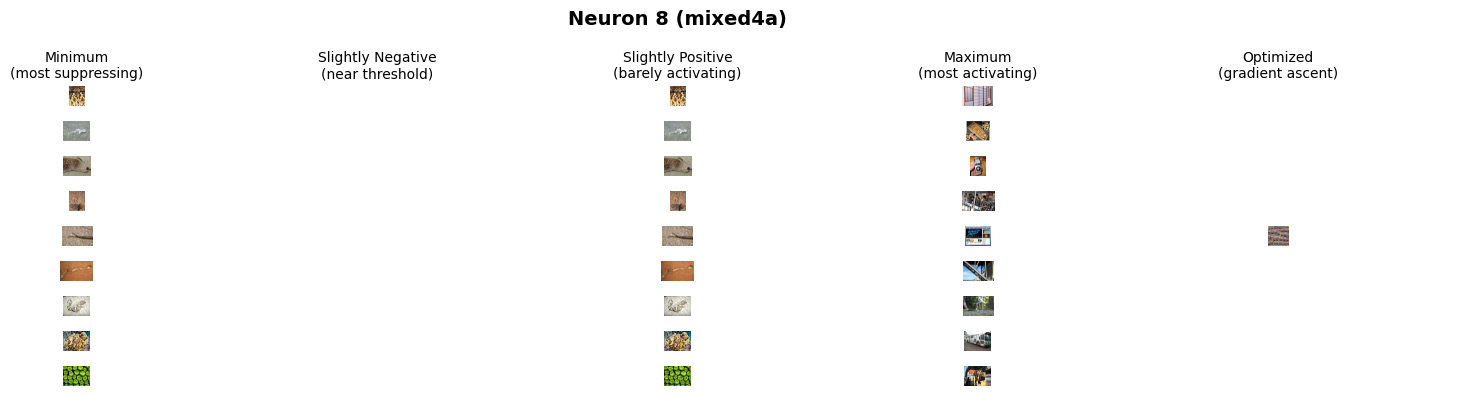

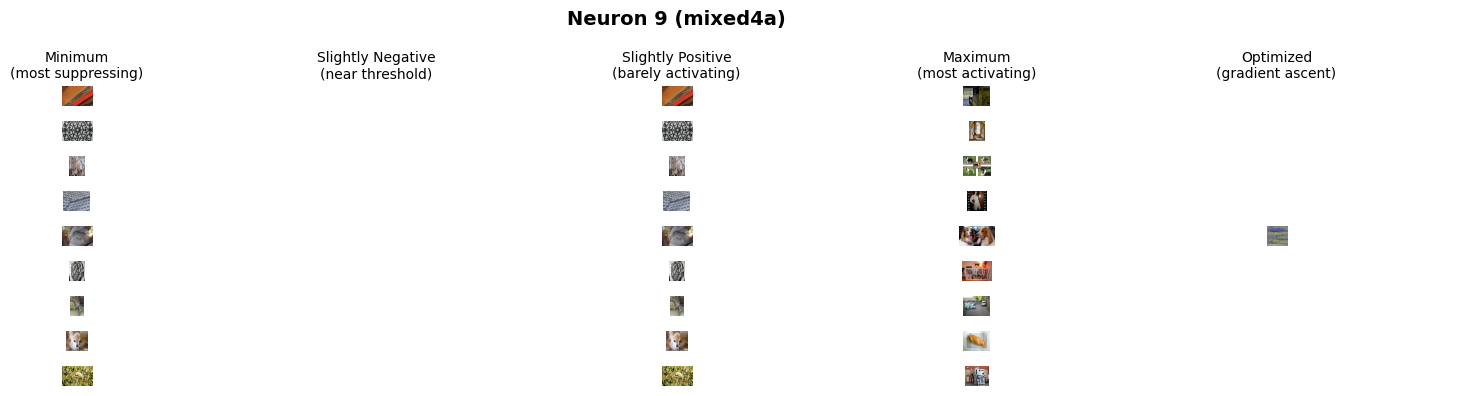

In [10]:
# Visualize spectrum for all tracked neurons
print(f"Visualizing activation spectrum for {CONFIG['num_neurons']} neurons...\n")

figures = []
for n in range(CONFIG["num_neurons"]):
    spectrum = tracker.get_spectrum(n)
    opt_img = optimized_images.get(n)
    
    fig = plot_neuron_spectrum(n, spectrum, opt_img)
    figures.append(fig)
    plt.show()
    print()

## 8. Log Results to WANDB

In [11]:
print("Logging results to WANDB...")

# Log spectrum grids as images
for n, fig in enumerate(figures):
    wandb.log({f"spectrum/neuron_{n}": wandb.Image(fig)})
    plt.close(fig)

# Create summary table
columns = ["Neuron", "Category", "Rank", "Activation", "Label", "Image"]
table = wandb.Table(columns=columns)

for n in range(CONFIG["num_neurons"]):
    spectrum = tracker.get_spectrum(n)
    for category in ["minimum", "slight_negative", "slight_positive", "maximum"]:
        samples = spectrum.get(category, [])
        for rank, sample in enumerate(samples):
            if isinstance(sample.image, Image.Image):
                table.add_data(
                    n,
                    category,
                    rank,
                    sample.activation,
                    sample.label,
                    wandb.Image(sample.image),
                )

wandb.log({"activation_spectrum_table": table})

# Log optimized images
if CONFIG["generate_optimized"]:
    for n, img in optimized_images.items():
        if img is not None:
            wandb.log({f"optimized/neuron_{n}": wandb.Image(img)})

print(f"Logged spectrum for {CONFIG['num_neurons']} neurons to WANDB")

Logging results to WANDB...
Logged spectrum for 10 neurons to WANDB


In [12]:
# Cleanup
extractor.remove_hook()
wandb.finish()

print("\n" + "="*50)
print("Pipeline complete!")
print(f"View results at: {run.url}")
print("="*50)

batch,▁▂▃▅▆▇█
samples_processed,▁▂▃▅▆▇█
batch,70
samples_processed,8960



Pipeline complete!
View results at: https://wandb.ai/cataluna84/vision-interpretability/runs/1olpoehn


## 9. Analysis & Insights

### Interpreting the Activation Spectrum

For each neuron, compare:

1. **Minimum vs Maximum**: What visual features distinguish them? Maximum activators show what the neuron detects; minimum show what it avoids.

2. **Slight Negative vs Slight Positive**: The decision boundary—what small difference causes the neuron to "fire"?

3. **Maximum vs Optimized**: The optimized image shows the "platonic ideal" of what the neuron wants. Real images are constrained by natural statistics.

### Common Patterns in Mixed4a

- Lower-indexed neurons often detect simple patterns (edges, textures)
- Higher-indexed neurons may detect more complex features (parts of objects)
- Some neurons are "multi-faceted", responding to several distinct patterns